In [1]:
import os
import json
import warnings
import optuna
import numpy as np
import pandas as pd
from io import StringIO
from pathlib import Path
from datetime import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, sum_models

from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor

warnings.filterwarnings("ignore")

/home/h24116049/miniconda3/envs/aicup2024-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
for i in range(1, 18):
    dataset_dir = os.getcwd() + f"/L{i}_Train.csv"
    print(dataset_dir)
    df = pd.read_csv(dataset_dir)

    # with additional data
    # if i in [2, 4, 7, 8, 9, 10, 12]:
    #     addition_dir = os.getcwd() + f"/36_TrainingData_Additional_V2/L{i}_Train_2.csv"
    #     df2 = pd.read_csv(addition_dir)
    #     df = pd.concat([df, df2], axis = False)

    df['DateTime'] = pd.to_datetime(df['DateTime'])
    col = df.pop("Power(mW)")
    df["Power(mW)"] = col

    df.set_index('DateTime', inplace=True)
    df = df.resample('10T').mean()
    df = df.round(2)

    df.reset_index(inplace=True)
    # df.replace("", np.nan, inplace=True)
    df = df.dropna()

    df.to_csv(os.getcwd() + f"/TrainingData_avg/L{i}_Train.csv", index=False)

/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L1_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L2_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L3_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L4_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L5_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L6_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L7_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L8_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L9_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L10_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L11_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L12_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazzz/DS_Dataset/L13_Train.csv
/home/h24116049/project/AI-CUP-2024/BlaBlaBlazz

In [4]:
target_dir = os.getcwd() + f"/upload.csv"
target = pd.read_csv(target_dir, encoding='utf8')['序號'].values

date_device = {}
for item in target:
    date = str(item)[:8]
    device = str(item)[12:]
    dd = date + device

    if dd not in date_device.keys():
        date_device[dd] = [int(device)]
        
data_ls = []

for date in list(date_device.keys()):
    # traverse all dataset to find target days
    for i in range(1, 18):
        data_dir = os.getcwd() + f"/TrainingData_avg/L{i}_Train.csv"
        data = pd.read_csv(data_dir)
        data['DateTime'] = pd.to_datetime(data['DateTime'])
        data_ls.append(data)  # store data

        date_ls = data['DateTime'].dt.strftime("%Y%m%d").values

        if date[:-2] in date_ls and i not in date_device[date]:
            date_device[date].append(i)

# write file        
with open("target_match_device.txt", 'w') as file:
    file.write(json.dumps(date_device))

date_device


KeyboardInterrupt: 

In [5]:
def make_date_device(data_ls):
    target_dir = os.getcwd() + f"/upload.csv"
    target = pd.read_csv(target_dir, encoding='utf8')['序號'].values

    date_device = {}
    for item in target:
        date = str(item)[:8]
        device = str(item)[12:]
        dd = date + device

        if dd not in date_device.keys():
            date_device[dd] = [int(device)]
    # data_ls = load_data()

    for date in list(date_device.keys()):
        year = date[:4]
        month = date[4:6]
        day = date[6:-2]

        start_time = pd.Timestamp(f"{year}-{month}-{day} 09:00:00")
        end_time = pd.Timestamp(f"{year}-{month}-{day} 16:50:00")
        # traverse all dataset to find target days
        for i in range(1, 18):
            data = data_ls[i-1]

            filtered_df = data[(data['DateTime'] >= start_time) & (data['DateTime'] <= end_time)]
            if len(filtered_df)>40:
                date_device[date].append(i)
    
    # write file        
    with open("target_match_device.txt", 'w') as file:
        file.write(json.dumps(date_device))

    return date_device

date_device = make_date_device(data_ls)

In [6]:
def feature_engineering(df):
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['minute'] = df['DateTime'].dt.minute
    baseline_date = pd.to_datetime('2024-01-01')
    df['days'] = (df['DateTime'] - baseline_date).dt.days  # distance to the baseline date(2024-01-01)
    df['month'] = df['DateTime'].dt.month


    # df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    # df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 24)
    # df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 24)

    df['sun_power_inter'] = df['Sunlight(Lux)'] * df['Power(mW)']

    df['lag_sunlight'] = df['Sunlight(Lux)'].shift(1)
    df['lag_power'] = df['Power(mW)'].shift(1)

    df.drop(columns=['DateTime', 'LocationCode'], inplace=True)
    # df.drop(columns=['idx', 'DateTime', 'LocationCode', 'height', 'angle', 'is_upper', 'Sunlight(Lux)'], inplace=True)
    return df

def load_data():
    data_ls = []
    for i in range(1, 18):
        # data_dir = os.getcwd() + f"/TrainingData_avg/L{i}_Train.csv"
        data_dir = os.getcwd() + f"/TrainingData_avg/L{i}_Train.csv"
        data = pd.read_csv(data_dir)
        data['DateTime'] = pd.to_datetime(data['DateTime'])
        data.dropna(axis=0, how='any', inplace=True)
        data_ls.append(data)  # store data
    
    return data_ls

def load_date_device_dict():
    with open(os.getcwd() + "/target_match_device.txt") as f:
        date_dict = f.read()
    
    return json.loads(date_dict)



def get_intersection_date(data, id1, id2, date_id, month):
    data1 = data[id1-1]
    data2 = data[id2-1]

    # if month in [1, 2, 3, 4]:
    #     data1 = data1[data1['month'].isin([1, 2, 3, 4])]
    #     data2 = data2[data2['month'].isin([1, 2, 3, 4])]
    #     season = 1
    # elif month in [5, 6, 7, 8]:
    #     data1 = data1[data1['month'].isin([5, 6, 7, 8])]
    #     data2 = data2[data2['month'].isin([5, 6, 7, 8])]
    #     season = 2
    # else:
    #     data1 = data1[data1['month'].isin([9, 10, 11, 12, ])]
    #     data2 = data2[data2['month'].isin([9, 10, 11, 12])]
    #     season = 3

    # data1 = data1[data1['month'] == int(month)]
    # data2 = data2[data2['month'] == int(month)]

    target = data1[data1['DateTime'].isin(data2['DateTime'])].reset_index(drop=True)  # assign divice1 to the target power
    target.rename(columns={'Power(mW)': 'Label'}, inplace=True)
    target = target['Label']
    match2 = data2[data2['DateTime'].isin(data1['DateTime'])].reset_index(drop=True)

    # target test data
    start_time = pd.to_datetime(f"{date_id}0900", format='%Y%m%d%H%M')
    # print(start_time)
    end_time = pd.to_datetime(f"{date_id}1650", format='%Y%m%d%H%M')
    # print(end_time)
    test_data = data2[(data2['DateTime'] >= start_time) & (data2['DateTime'] <= end_time)].reset_index(drop=True)

    match2 = feature_engineering(match2)
    test_data = feature_engineering(test_data)

    return match2, target, test_data


def split_train_val_test(df, label):
    X_train, X_val, y_train, y_val = train_test_split(df, label, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

def normalize_features(X_train, X_val, X_test):
    min_max_scaler = preprocessing.MinMaxScaler()

    X_train_scaled = min_max_scaler.fit_transform(X_train)
    X_val_scaled = min_max_scaler.transform(X_val)
    X_test_scaled = min_max_scaler.transform(X_test)

    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).astype(float)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns).astype(float)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).astype(float)

    return X_train_scaled_df, X_val_scaled_df, X_test_scaled_df


def complete_target_time():
    target_time = []
    for hour in range(9, 17):
        for minute in range(0, 60, 10):
            if hour == 16 and minute > 50:
                break
            target_time.append((hour, minute))
    
    return target_time


def fillna(X_test):
    target_time = complete_target_time()
    time_df = pd.DataFrame(target_time, columns=["hour", "minute"])

    df = time_df.merge(
        X_test,
        on=["hour", "minute"],
        how="left"
    )
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True) 
    df = df[X_test.columns]

    return df

def get_avg_of_closest4(data, date_id, result):
    df = feature_engineering(data)
    target_time = complete_target_time()

    # days from 2024-01-01
    date = pd.to_datetime(f"{date_id[:4]}-{date_id[4:6]}-{date_id[6:]}")
    baseline_date = pd.to_datetime('2024-01-01')
    target_day = (date - baseline_date).days

    for (hour, minute) in target_time:
        time_data = df[(df['hour'] == hour) & (df['minute'] == minute)]
        date_diff = np.abs(time_data['days'] - target_day)
        closest4_days = time_data.iloc[np.argsort(date_diff)[:4]]
        
        average_power = closest4_days['Power(mW)'].mean()
        result.append(np.round(average_power, 2))
    
    return result


def train_model(X_train, y_train, X_val, y_val):
    model = XGBRegressor(n_estimators=100, random_state=42, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    return model, mse, mae

def evaluate_metrics(model, X_val, y_val):
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    return mse, mae

def run(beta):
    data_ls = load_data()
    date_device = load_date_device_dict()
    total_mse = 0
    total_mae = 0
    
    result = []
    model_cache = {}

    gg = {"2024011701": [1, 8, 17]}

    for idx, (date_id, device_ls) in enumerate(date_device.items()):
        date_id = date_id[:-2]
        month = int(date_id[4:6])

        best_mse = float('inf')
        best_mae = float('inf')
        best_model = None
        best_device = None
        
        sum_results = None
        model_weights = []
        model_pred = []

        # no data found in other device, take average of 4 closest days
        if len(device_ls) == 1:
            data = data_ls[device_ls[0]-1]  # data of target device
            result = get_avg_of_closest4(data, date_id, result)

            print("current problem: {}/200 | No device, fill with average power in 4 days".format(idx+1))

        else:
            model_len = len(device_ls[1:])
            for dev_idx, dev in enumerate(device_ls[1:]):
                train_data, label_data, X_test = get_intersection_date(data_ls, device_ls[0], dev, date_id, month)
                X_train, X_val, y_train, y_val = split_train_val_test(train_data, label_data)
                if X_test.shape[0] < 48:
                    X_test = fillna(X_test)
                # output[idx].append(48 - X_test.shape[0])

                # X_train, X_val, X_test = normalize_features(X_train, X_val, X_test)
                
                if (device_ls[0], dev) not in list(model_cache.keys()):
                    epoch_model, epoch_mse, epoch_mae = train_model(X_train, y_train, X_val, y_val)
                    model_cache[(device_ls[0], dev)] = [epoch_model, epoch_mse, epoch_mae]  # store pair model in cache
                else:
                    epoch_model, epoch_mse, epoch_mae = model_cache[(device_ls[0], dev)]
                
                # model_weights.append(1 / epoch_mae)
                model_weights.append(epoch_mae)

                if epoch_mae < best_mae:
                    best_model = epoch_model
                    best_mse = epoch_mse
                    best_mae = epoch_mae
                    best_device = dev
                
                # aggregate test data
                # weighted_prediction = epoch_model.predict(X_test) * (1/epoch_mae)
                # sum_results = weighted_prediction if sum_results is None else sum_results + weighted_prediction
                predictions = epoch_model.predict(X_test)
                model_pred.append(predictions)

            
            total_mse += best_mse
            total_mae += best_mae
            
            print("current problem: {}/200 | Best MSE: {} | Best MAE: {} in Device {}".format(idx+1, best_mse, best_mae, best_device))
            
            # epoch_result = np.round(sum_model.predict(X_test), 2)
            # epoch_result = np.round(sum_results / sum(model_weights), 2)
            # beta = 0.05
            # print((1/np.array(model_weights)) / sum((1/np.array(model_weights))))
            model_weights = np.exp(-beta * np.array(model_weights))
            model_weights = model_weights / np.sum(model_weights)
            # print(model_weights)
            epoch_result = np.sum(np.array(model_pred).T * model_weights, axis=1)
            epoch_result = np.round(epoch_result, 2)
            result.extend(epoch_result)
        # display(X_test)

    print("All questions finished, Total MSE: {} | Total MAE: {}".format(total_mse, total_mae))
    

    return result



# result = run()
# with open('result.txt', 'w') as f:
#     for line in result:
#         f.write(f"{line}\n")

    
    

In [22]:
target_dir = os.getcwd() + f"/results/upload.csv"
upload = pd.read_csv(target_dir)

# result = [0 if r<0 else r for r in result]
result = np.round(result, 2)
upload['答案'] = result
upload.to_csv(os.getcwd() + "/results/upload_v1.csv", index=False)

In [12]:
result = pd.read_csv('results/upload_v1.csv')
answer = pd.read_csv("answer.csv")
result['answer'] = answer['答案']
result['mask'] = answer['mask']

print(answer[answer['mask']==0].shape)
print(answer[answer['mask']==1].shape)

print(mean_absolute_error(answer[answer['mask'] == 0]['答案'], result[result['mask'] == 0]['答案']) * 4800)
print(mean_absolute_error(answer[answer['mask'] == 1]['答案'], result[result['mask'] == 1]['答案']) * 4800)
print(mean_absolute_error(answer['答案'], result['答案']) * answer.shape[0])

(4800, 3)
(4800, 3)
402801.09
336128.12
738929.21


In [16]:
# beta analysis

target_dir = os.getcwd() + f"/results/upload.csv"

answer = pd.read_csv("answer.csv")
betas = [0.01, 0.03, 0.04, 0.05, 0.07, 0.08, 0.1, 0.12, 0.13, 0.14, 0.15, 0.2, 0.5]
public_mae_ls = []
private_mae_ls = []

for beta in betas:
    result = run(beta)

    upload = pd.read_csv(target_dir)
    upload['答案'] = result
    upload['mask'] = answer['mask']
    public_mae = mean_absolute_error(answer[answer['mask'] == 0]['答案'], upload[upload['mask'] == 0]['答案']) * 4800
    private_mae = mean_absolute_error(answer[answer['mask'] == 1]['答案'], upload[upload['mask'] == 1]['答案']) * 4800

    public_mae_ls.append(public_mae)
    private_mae_ls.append(private_mae)





current problem: 1/200 | Best MSE: 39516.58978537309 | Best MAE: 95.67275625683166 in Device 17
current problem: 2/200 | Best MSE: 17669.655710440253 | Best MAE: 66.61758409548038 in Device 8
current problem: 3/200 | Best MSE: 1658.2802167874438 | Best MAE: 15.48400813324804 in Device 2
current problem: 4/200 | Best MSE: 1658.2802167874438 | Best MAE: 15.48400813324804 in Device 2
current problem: 5/200 | Best MSE: 39516.58978537309 | Best MAE: 95.67275625683166 in Device 17
current problem: 6/200 | Best MSE: 1658.2802167874438 | Best MAE: 15.48400813324804 in Device 2
current problem: 7/200 | Best MSE: 1658.2802167874438 | Best MAE: 15.48400813324804 in Device 2
current problem: 8/200 | Best MSE: 1658.2802167874438 | Best MAE: 15.48400813324804 in Device 2
current problem: 9/200 | Best MSE: 1658.2802167874438 | Best MAE: 15.48400813324804 in Device 2
current problem: 10/200 | Best MSE: 1658.2802167874438 | Best MAE: 15.48400813324804 in Device 2
current problem: 11/200 | Best MSE: 165

In [17]:
private_mae_ls

[452329.93,
 380638.43,
 355073.54000000004,
 336128.12,
 313367.06,
 306828.56,
 299815.49,
 297416.61000000004,
 296929.45,
 296731.61,
 296754.91000000003,
 298203.24,
 308714.67000000004]

In [23]:
public_mae_ls

[507208.37,
 443270.05999999994,
 420284.05000000005,
 402801.09,
 380466.19999999995,
 373652.68000000005,
 365521.24,
 362301.01,
 361742.88,
 361608.24,
 361776.76,
 364207.82000000007,
 375593.21]

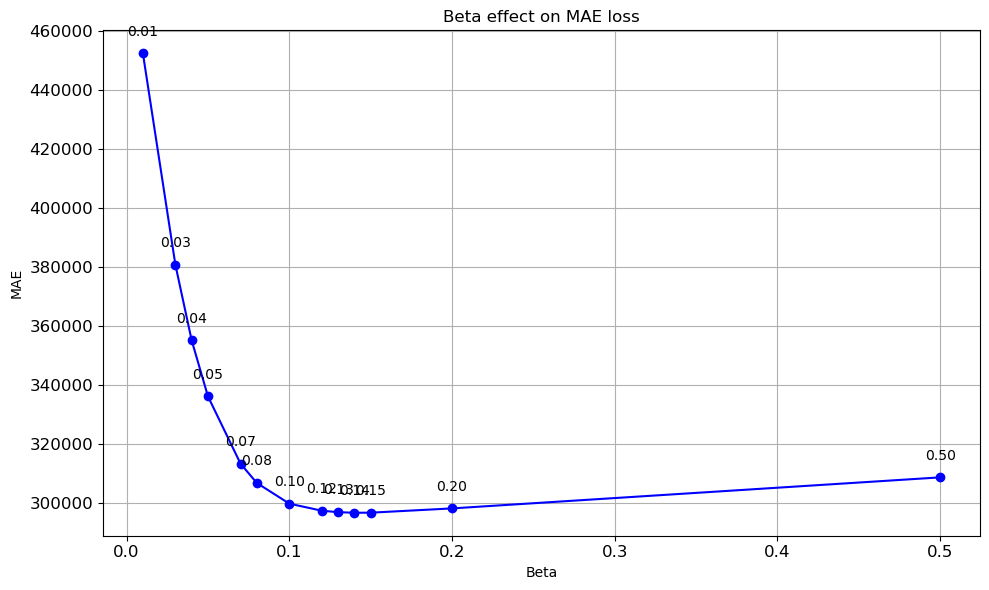

In [2]:
import matplotlib.pyplot as plt

betas = [0.01, 0.03, 0.04, 0.05, 0.07, 0.08, 0.1, 0.12, 0.13, 0.14, 0.15, 0.2, 0.5]
private_mae_ls = [452329.93, 380638.43, 355073.54, 336128.12, 313367.06, 306828.56, 299815.49, 297416.61, 296929.45, 296731.61, 296754.91, 298203.24, 308714.67]
plt.figure(figsize=(10, 6))
plt.plot(betas, private_mae_ls, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Beta effect on MAE loss')
plt.xlabel('Beta')
plt.ylabel('MAE')
plt.grid(True)

for beta, loss in zip(betas, private_mae_ls):
    plt.text(beta, loss + 5000, f"{beta:.2f}", fontsize=10, ha='center', va='bottom')


# Show the plot
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()  # 自動調整間距
plt.show()

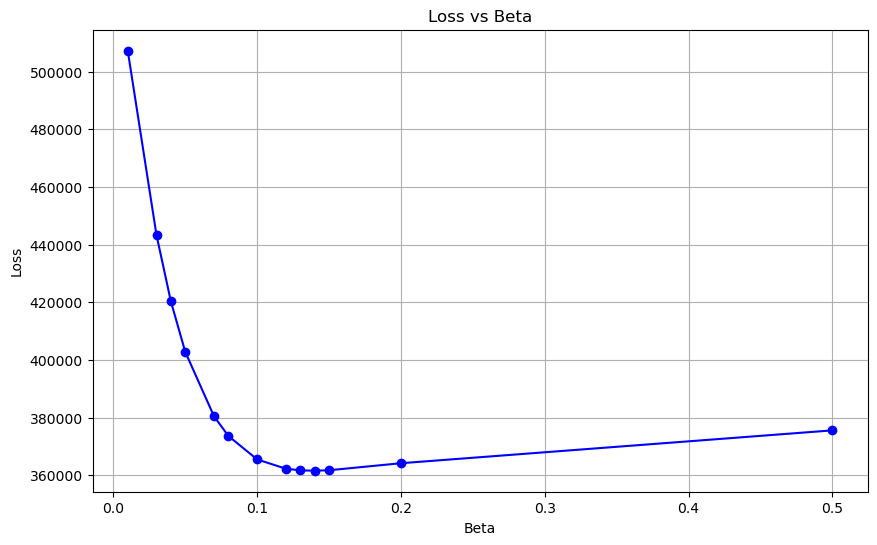

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(betas, public_mae_ls, marker='o', linestyle='-', color='b')

plt.title('Loss vs Beta')
plt.xlabel('Beta')
plt.ylabel('Loss')
plt.grid(True)

# Show the plot
plt.show()

In [23]:
answer = pd.read_csv("answer.csv")

print(mean_absolute_error(answer['答案'], result) * answer.shape[0])

738929.21


In [77]:
dir = os.getcwd() + f"/results/upload_v13.csv"
compare = pd.read_csv(dir)

dir2 = os.getcwd() + f"/results/upload_v7.csv"
compare2 = pd.read_csv(dir2)

dir3 = os.getcwd() + f"/results/upload_v14.csv"
compare3 = pd.read_csv(dir3)

print(mean_absolute_error(compare['答案'], compare2['答案']) * compare.shape[0])
print(mean_absolute_error(compare['答案'], compare3['答案']) * compare.shape[0])
print(mean_absolute_error(compare['答案'], result) * compare.shape[0])

# sum(abs(compare['答案'] -  compare2['答案']))

415160.25
81559.71999999999
160038.77000000002


In [29]:
d = load_date_device_dict()
data_ls = load_data()
intersection, target, X_test = get_intersection_date(data_ls, 1, 8, '20240117', 1)
display(intersection)


X_train, X_val, y_train, y_val = split_train_val_test(intersection, target)
# X_train, X_val, X_test = normalize_features(X_train, X_val, X_test)
X_train

,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Power(mW),year,month,day,hour,minute,SunlightPred,sun_power_inter,lag_sunlight,lag_power
0,0.06,1016.07,14.61,81.04,0.00,2024,1,6,6,20,45.00,0.0000,NaN,NaN
1,0.00,1016.12,14.59,81.11,0.00,2024,1,6,6,30,172.87,0.0000,45.00,0.00
2,0.00,1016.35,14.64,80.79,0.02,2024,1,6,6,40,437.40,8.7480,172.87,0.00
3,0.00,1016.51,14.46,81.80,0.06,2024,1,6,6,50,781.25,46.8750,437.40,0.02
4,0.00,1016.60,14.46,82.03,0.15,2024,1,6,7,0,1211.08,181.6620,781.25,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7809,0.00,1006.21,34.09,59.96,5.05,2024,7,198,9,50,4063.25,20519.4125,4103.98,5.23
7810,0.00,1006.18,34.29,60.79,4.94,2024,7,198,10,0,4010.42,19811.4748,4063.25,5.05
7811,0.00,1006.22,34.24,61.58,4.68,2024,7,198,10,10,3967.17,18566.3556,4010.42,4.94
7812,0.00,1006.22,34.48,61.75,4.57,2024,7,198,10,20,3934.83,17982.1731,3967.17,4.68


,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Power(mW),year,month,day,hour,minute,SunlightPred,sun_power_inter,lag_sunlight,lag_power
1158,2.29,1017.71,17.41,90.21,0.00,2024,1,30,6,20,58.93,0.0000,42.62,0.00
5861,0.00,1004.82,30.85,100.00,0.81,2024,6,152,17,10,1878.17,1521.3177,2880.25,1.88
3731,0.00,1008.27,27.25,69.07,51.61,2024,3,90,9,30,15091.58,778876.4438,13812.42,44.79
6142,0.00,1006.55,29.05,74.22,0.63,2024,6,156,16,0,1597.25,1006.2675,1917.25,0.96
4267,0.00,1010.51,24.90,100.00,1.32,2024,5,122,9,30,2510.08,3313.3056,4587.00,4.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.00,1005.79,24.74,100.00,0.81,2024,5,142,6,0,1815.33,1470.4173,1285.33,0.42
5390,0.00,1006.46,25.80,100.00,0.77,2024,5,144,6,0,1767.42,1360.9134,1336.75,0.43
860,0.00,1025.41,13.74,65.97,0.07,2024,1,24,7,10,612.00,42.8400,402.25,0.03
7603,0.00,1005.16,29.80,90.47,3.45,2024,7,195,7,30,3766.25,12993.5625,3617.42,3.05


In [30]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=0)
# rf_model = XGBRegressor(n_estimators=100, random_state=42)
# rf_model = LGBMRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 預測測試集的發電量
y_pred = rf_model.predict(X_val)

# 評估模型：計算RMSE
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

# 顯示模型的預測結果
print("預測發電量:", y_pred)
print("實際發電量:", y_val.values)

# 顯示特徵重要性
print("特徵重要性:", rf_model.feature_importances_)

MSE: 24198.907256138
MAE: 68.56552968650033
預測發電量: [  4.7562   0.6954  19.4188 ... 395.2528 124.9503  71.7518]
實際發電量: [  4.46   0.77  19.16 ... 370.89 115.97   8.11]
特徵重要性: [0.04327671 0.0503296  0.03809312 0.10990006 0.23057731 0.
 0.0036283  0.04330786 0.09518991 0.00450682 0.32196967 0.01623793
 0.01417633 0.02880638]


In [24]:
sum(y_pred<0)

324

In [98]:
np.set_printoptions(suppress=True)
pred = np.round(rf_model.predict(X_test), 2)

In [99]:
y = np.array([1277.55,1369.8,  1462.67, 1540.4,  1594.3,  1631.14, 1659.6,  1671.31, 1674.38,
 1669.7,  1689.69, 1708.54, 1710.23, 1734.19, 1727.19, 1760.06, 1766.71, 1728.95,
 1705.11, 1703.99, 1733.1,  1664.08, 1791.86, 1791.78, 1329.92,  417.97,  291.34,
  195.89,  160.57,  122.99,  105.78,   81.01,   56.43,   36.42,   26.28,   22.13,
   22.02,   19.7,    15.99,   14.8,    12.8,     9.86,    6.89,    4.8,     3.92,
    3.5,     1.72,    0.58])

mean_absolute_error(pred, y)

148.87354166666665

In [ ]:
# for k, v in output.items():
#         if 0 not in v:
#             print(k)
        
#     with open("xtest_num.txt", 'w') as file:
#         file.write(json.dumps(output))

# 156
# 157
# 183
# 189
# 191
# 192